<a href="https://colab.research.google.com/github/h-ueno2/intern_sample/blob/main/image_classification_cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディープラーニングを使用した画像分類の実例
ディープラーニングを用いて画像の分類を行います。  
今回は画像分類のチュートリアルにて猫と犬の画像の分類を実践してみます。


## ライブラリのインポート
Pythonにおけるディープラーニングのライブラリとしては以下が有名です。
- TensorFlow および Keras
- PyTorch

今回の例ではTensorFlowおよびKerasを使用してみましょう。

In [3]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import utils as np_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D

## データの取得
今回使用するデータを取得します。  

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # 学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs')  # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 検証用の犬画像のディレクトリ

犬と猫の画像はそれぞれ`train`という学習用の画像セットと`validation`という検証用の画像のセットに分類されています。  
では、それぞれの画像の数を確認してみましょう。

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


一旦ここで、この後に使用するネットワークの学習用の定数を設定しておきます。

In [6]:
BATCH_SIZE = 128
epochs = 10
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

# データの準備


In [7]:
# 教師データ
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
# 検証データ
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)

# テストデータセット
validation_dataset = validation_dataset.skip(val_batches // 5)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


試しに画像を表示してみます。

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

## モデルの作成
画像を分類するためのモデルを作成しましょう。

In [69]:
def sample_model():
    # モデルの構成を定義します。
    inputs = Input(shape=IMG_SHAPE)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset= -1)(inputs) # データを0-1の範囲に正規化
    x = Conv2D(16, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # モデルのコンパイル
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# モデルを作成
model = sample_model()

# モデルの構造を確認します
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 40, 40, 64)        184

## モデルの学習

それでは作成したモデルを学習してみましょう。

In [64]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
16/16 [==============================] - 6s 274ms/step - loss: 0.8430 - accuracy: 0.5285 - val_loss: 0.6928 - val_accuracy: 0.5023
Epoch 2/10
16/16 [==============================] - 5s 263ms/step - loss: 0.6784 - accuracy: 0.5540 - val_loss: 0.6773 - val_accuracy: 0.5390
Epoch 3/10
16/16 [==============================] - 5s 264ms/step - loss: 0.6433 - accuracy: 0.6465 - val_loss: 0.6286 - val_accuracy: 0.6479
Epoch 4/10
16/16 [==============================] - 5s 262ms/step - loss: 0.5912 - accuracy: 0.6910 - val_loss: 0.6388 - val_accuracy: 0.5998
Epoch 5/10
16/16 [==============================] - 5s 263ms/step - loss: 0.5548 - accuracy: 0.7230 - val_loss: 0.5849 - val_accuracy: 0.6812
Epoch 6/10
16/16 [==============================] - 5s 262ms/step - loss: 0.5029 - accuracy: 0.7590 - val_loss: 0.6224 - val_accuracy: 0.6468
Epoch 7/10
16/16 [==============================] - 5s 266ms/step - loss: 0.4580 - accuracy: 0.7930 - val_loss: 0.5621 - val_accuracy: 0.7259
Epoch 

学習結果を可視化してみましょう。

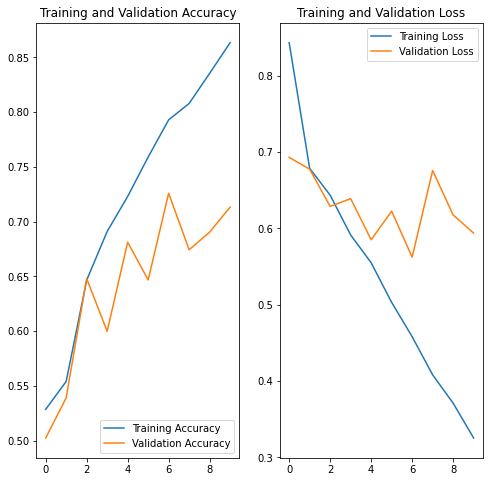

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# モデルの転移学習

先程のように何もない状態からニューラルネットワークのモデルを構築することは実際の業務ではあまりなく、基本的には公開されている既に構築済み/事前学習済みのモデルをベースとすることが多いです。  

今回はVGG19というモデルをImageNetというデータセットで事前学習済みのモデルをベースとし、転移学習しましょう。


In [11]:
# ベースモデルを用意
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

## 画像データの準備
先程のモデルでは画像のデータに対して1～0の範囲で正規化を行いました。


使用するモデルによって、データの範囲が異なります。  
使用するライブラリによっては前処理用のメソッドが用意されています。今回はその前処理用のメソッドを利用します。

In [10]:
# モデル用の画像前処理のレイヤーを用意。
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## モデルの構築

In [15]:
def create_model():
    # モデルの構成を定義します。
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    # モデルのコンパイル
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


ではこのモデルを転移学習してみましょう。

In [16]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


16/16 [==============================] - 16s 587ms/step - loss: 0.9088 - accuracy: 0.4480 - val_loss: 0.8243 - val_accuracy: 0.4599
Epoch 2/10
16/16 [==============================] - 7s 387ms/step - loss: 0.7970 - accuracy: 0.5015 - val_loss: 0.7139 - val_accuracy: 0.5562
Epoch 3/10
16/16 [==============================] - 7s 387ms/step - loss: 0.6970 - accuracy: 0.5885 - val_loss: 0.6254 - val_accuracy: 0.6537
Epoch 4/10
16/16 [==============================] - 7s 393ms/step - loss: 0.6100 - accuracy: 0.6655 - val_loss: 0.5461 - val_accuracy: 0.7443
Epoch 5/10
16/16 [==============================] - 7s 392ms/step - loss: 0.5354 - accuracy: 0.7380 - val_loss: 0.4789 - val_accuracy: 0.8028
Epoch 6/10
16/16 [==============================] - 7s 393ms/step - loss: 0.4856 - accuracy: 0.7885 - val_loss: 0.4257 - val_accuracy: 0.8612
Epoch 7/10
16/16 [==============================] - 7s 388ms/step - loss: 0.4322 - accuracy: 0.8255 - val_loss: 0.3795 - val_accuracy: 0.8876
Epoch 8/10
16/16

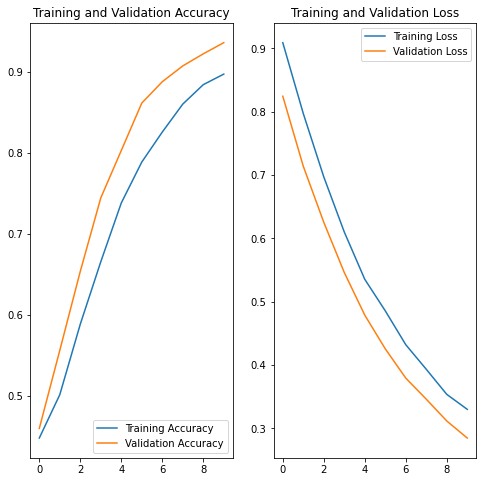

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()